In [1]:
from nilmtk import DataSet
from nilmtk.utils import print_dict
from sklearn.metrics import mean_absolute_error

In [2]:
import numpy as np
import pandas as pd
from os.path import join
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
#plt.style.use('ggplot')
from datetime import datetime as datetime2
from datetime import timedelta

import nilmtk
from nilmtk.disaggregate.maximum_likelihood_estimation import MLE
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from scipy.stats import poisson, norm
from sklearn import mixture
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_all_appliances(appliance):

    # Filtering by appliances: 
    print ("Fetching " + appliance + " over data loaded to nilmtk.")
    metergroup = nilmtk.global_meter_group.select_using_appliances(type=appliance)
    
    if len(metergroup.appliances) == 0: 
        print ("None " + appliance + " found on memory.")
        pass

    # Selecting only single meters: 
    print ("Filtering to get one meter for each " + appliance)

    meters = [meter for meter in metergroup.meters if (len(meter.appliances) == 1)]
    metergroup = MeterGroup(meters)
    print (metergroup)
    print ("Found " + str(len(metergroup.meters)) + " " + appliance)

    return metergroup


def get_all_trainings(appliance, train):

    # Filtering by appliances: 
    print ("Fetching ", appliance," over data train data.")
    elecs = []
    for building in train.buildings: 
        print ("Building " + str(building) + "...")
        try:
            elec = train.buildings[building].elec[appliance]
        except:
            continue
        if len(elec.appliances) == 1: 
            print (elec)
            print ("Fetched elec.")
            elecs.append(elec)

        else: 
            print (elec)
            print ("Groundtruth does not exist. Many appliances or None")

    metergroup = MeterGroup(elecs)

    return metergroup

In [4]:

redd = DataSet('/Users/guptasoumya/Desktop/capstone_nilmtk/nilmtk/data/REDD/redd.h5')
train = redd
test = redd
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")

## Fridge

In [5]:
applianceName = 'fridge'

In [6]:
metergroup = get_all_trainings(applianceName,train)

Fetching  fridge  over data train data.
Building 1...
ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.
Building 2...
ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.
Building 4...
Building 5...
ElecMeter(instance=18, building=5, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.
Building 6...
ElecMeter(instance=8, building=6, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.


In [7]:
mle = MLE()

In [8]:

# setting parameters in the model: 
mle.update(appliance=applianceName, resistive=True, units=('power','active'), thDelta= 100, thLikelihood= 1e-10, powerNoise= 5, powerPair= 600, timeWindow= 10, sample_period= '3S', sampling_method='first')

# Settings the features parameters by guessing:  
mle.onpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.offpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.duration = {'name':'gmm', 'model': mixture.GMM(n_components=10)}

Updating model
{'appliance': 'fridge', 'resistive': True, 'units': ('power', 'active'), 'thDelta': 100, 'thLikelihood': 1e-10, 'powerNoise': 5, 'powerPair': 600, 'timeWindow': 10, 'sample_period': '3S', 'sampling_method': 'first'}


Training on chunk
Samples of onpower: 26835
Samples of offpower: 26835
Samples of duration: 26835
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 4806
Samples of offpower: 4806
Samples of duration: 4806
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 14057
Samples of offpower: 14057
Samples of duration: 14057
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 4732
Samples of offpower: 4732
Samples of duration: 4732
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 15792
Samples of offpower: 15792
Samples of duration: 15792
Training onpower
Training offpower
Training duration
Training onpower
Training offpower
Training duration


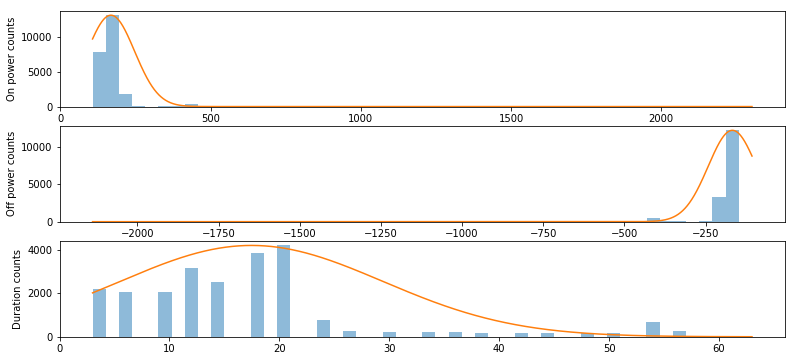

In [9]:
mle.train(metergroup)
mle.no_overfitting()
mle.featuresHist()

In [10]:
# Building to disaggregate: 
building = 1
mains = get_all_trainings(applianceName,test)

# File to store the disaggregation
filename= ('/Users/guptasoumya/Desktop/capstone_nilmtk/nilmtk/data/REDD/redd_mle_fridge1.h5')
output = HDFDataStore(filename, 'w')

Fetching  fridge  over data train data.
Building 1...
ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.
Building 2...
ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.
Building 4...
Building 5...
ElecMeter(instance=18, building=5, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.
Building 6...
ElecMeter(instance=8, building=6, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Fetched elec.


In [11]:
mle.disaggregate(mains, output)

Loading data for meter ElecMeterID(instance=8, building=6, dataset='REDD')      
Done loading data all meters for this chunk.
35120 events found.
16622 onEvents found
9756 onEvents no paired.
1 chunks disaggregated


In [12]:
## Groundtruth
building1 = test.buildings[building].elec
#building1[applianceName].plot()
#pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]].plot()

In [13]:
#building1 = test.building
test_output  = next(building1[applianceName].load())

In [14]:
predicted_output = pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]]

In [15]:
test_output = test_output.reset_index()
predicted_output = predicted_output.reset_index()

In [16]:
merge_output= test_output.merge(predicted_output, on= 'index',how='inner')

In [17]:
mle_fridge = mean_absolute_error(merge_output.iloc[:,1],merge_output.iloc[:,2])
mle_fridge

170.84703

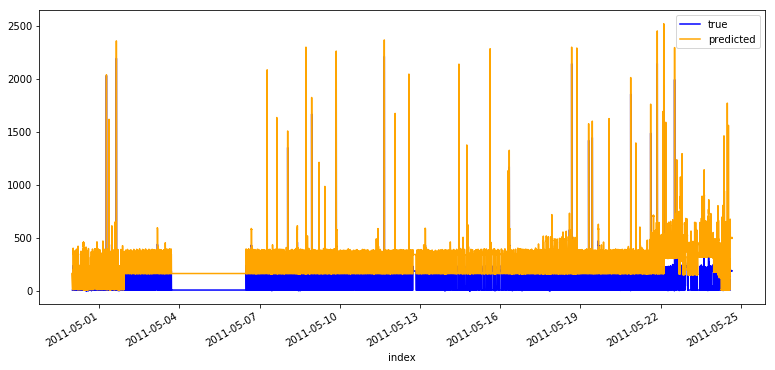

In [18]:
merge_output.set_index('index',inplace=True)
merge_output.iloc[:,0].plot(color='blue')
merge_output.iloc[:,1].plot(color='orange')
plt.legend(['true','predicted'])
plt.show()

## Dishwasher

In [19]:
applianceName = 'dish washer'
metergroup = get_all_trainings(applianceName,train)

Fetching  dish washer  over data train data.
Building 1...
ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 2...
ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=9, building=3, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 4...
ElecMeter(instance=15, building=4, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 5...
ElecMeter(instance=20, building=5, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 6...
ElecMeter(instance=9, building=6, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.


In [20]:
mle = MLE()

In [21]:

# setting parameters in the model: 
mle.update(appliance=applianceName, resistive=True, units=('power','active'), thDelta= 100, thLikelihood= 1e-10, powerNoise= 5, powerPair= 1200, timeWindow= 10, sample_period= '3S', sampling_method='first')

# Settings the features parameters by guessing:  
mle.onpower = {'name':'gmm', 'model': mixture.GMM(n_components=10)}
mle.offpower = {'name':'gmm', 'model': mixture.GMM(n_components=10)}
mle.duration = {'name':'gmm', 'model': mixture.GMM(n_components=10)}

Updating model
{'appliance': 'dish washer', 'resistive': True, 'units': ('power', 'active'), 'thDelta': 100, 'thLikelihood': 1e-10, 'powerNoise': 5, 'powerPair': 1200, 'timeWindow': 10, 'sample_period': '3S', 'sampling_method': 'first'}


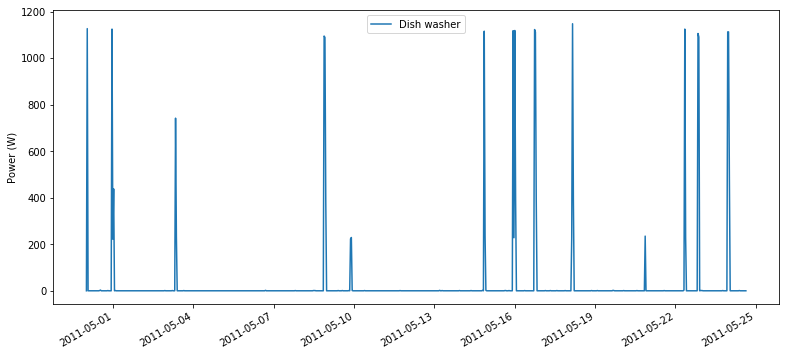

In [22]:
train.buildings[1].elec[applianceName].plot()

Training on chunk
Samples of onpower: 4704
Samples of offpower: 4704
Samples of duration: 4704
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 164
Samples of offpower: 164
Samples of duration: 164
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 397
Samples of offpower: 397
Samples of duration: 397
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 536
Samples of offpower: 536
Samples of duration: 536
Training onpower
Training offpower
Training duration
Training on chunk
            Is it thDelta too high?
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 2
Samples of offpower: 2
Samples of duration: 2
Training onpower
Training offpower
Training duration
Training onpower
Training offpower
Training duration


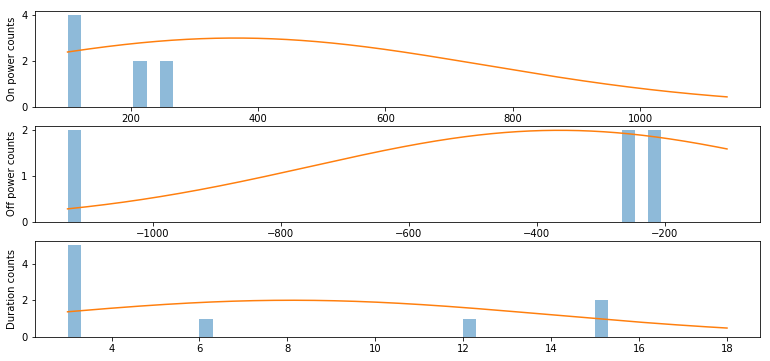

In [23]:
mle.train(metergroup)
mle.no_overfitting()
mle.featuresHist()

In [24]:
# Building to disaggregate: 
building = 1
mains = get_all_trainings(applianceName,test)

# File to store the disaggregation
filename= ('/Users/guptasoumya/Desktop/capstone_nilmtk/nilmtk/data/REDD/redd_mle_dishwasher1.h5')
output = HDFDataStore(filename, 'w')

Fetching  dish washer  over data train data.
Building 1...
ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 2...
ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=9, building=3, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 4...
ElecMeter(instance=15, building=4, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 5...
ElecMeter(instance=20, building=5, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.
Building 6...
ElecMeter(instance=9, building=6, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
Fetched elec.


In [25]:
mle.disaggregate(mains, output)

Loading data for meter ElecMeterID(instance=9, building=6, dataset='REDD')      
Done loading data all meters for this chunk.
3052 events found.
1174 onEvents found
548 onEvents no paired.
1 chunks disaggregated


In [26]:
test_output  = next(building1[applianceName].load())

predicted_output = pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]]

test_output = test_output.reset_index()
predicted_output = predicted_output.reset_index()

merge_output= test_output.merge(predicted_output, on= 'index',how='inner')

mle_dishwasher = mean_absolute_error(merge_output.iloc[:,1],merge_output.iloc[:,2])
mle_dishwasher

4.941888

In [27]:
merge_output.set_index('index',inplace=True)
merge_output.head()

physical_quantity,power_x,power_y
type,active,active
index,,
2011-04-30 00:00:09-04:00,1136.0,1137.0
2011-04-30 00:00:12-04:00,1135.0,1135.0
2011-04-30 00:00:24-04:00,1136.0,1137.0
2011-04-30 00:00:27-04:00,1134.0,1135.0
2011-04-30 00:00:42-04:00,1133.0,1133.0


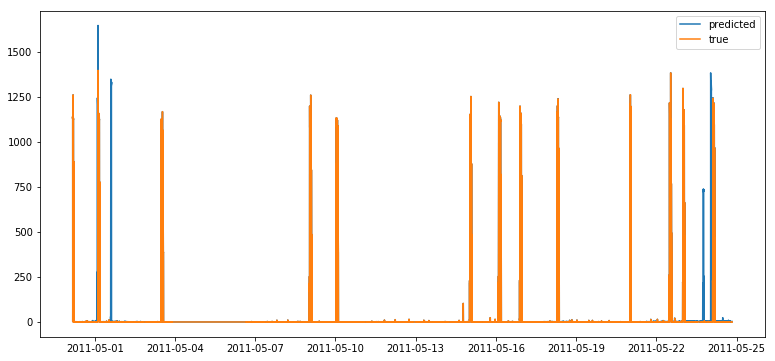

In [28]:
plt.plot(merge_output.iloc[:,1])
plt.plot(merge_output.iloc[:,0])
plt.legend(['predicted','true'])
plt.show()


## Light

In [29]:
applianceName = 'light'
metergroup = get_all_trainings(applianceName,train)

Fetching  light  over data train data.
Building 1...
ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 2...
ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=5, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 4...
ElecMeter(instance=3, building=4, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 5...
ElecMeter(instance=4, building=5, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 6...
ElecMeter(instance=14, building=6, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.


In [30]:
mle = MLE()

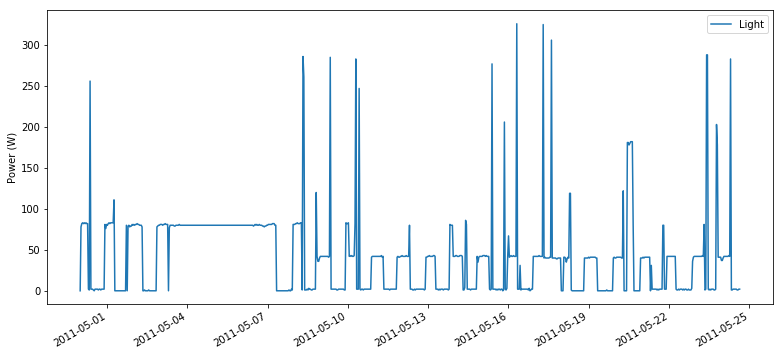

In [31]:
train.buildings[1].elec[applianceName].plot()

In [32]:

# setting parameters in the model: 
mle.update(appliance=applianceName, resistive=True, units=('power','active'), thDelta= 25, thLikelihood= 1e-10, powerNoise= 5, powerPair= 400, timeWindow= 10, sample_period= '3S', sampling_method='first')

# Settings the features parameters by guessing:  
mle.onpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.offpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.duration = {'name':'gmm', 'model': mixture.GMM(n_components=10)}


Updating model
{'appliance': 'light', 'resistive': True, 'units': ('power', 'active'), 'thDelta': 25, 'thLikelihood': 1e-10, 'powerNoise': 5, 'powerPair': 400, 'timeWindow': 10, 'sample_period': '3S', 'sampling_method': 'first'}


Training on chunk
Samples of onpower: 54962
Samples of offpower: 54962
Samples of duration: 54962
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 492
Samples of offpower: 492
Samples of duration: 492
Training onpower
Training offpower
Training duration
Training on chunk
            Is it thDelta too high?
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 11553
Samples of offpower: 11553
Samples of duration: 11553
Training onpower
Training offpower
Training duration
Training on chunk
            Is it thDelta too high?
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 30303
Samples of offpower: 30303
Samples of duration: 30303
Training onpower
Training offpower
Training duration
Training onpower
Training offpower
Training duration


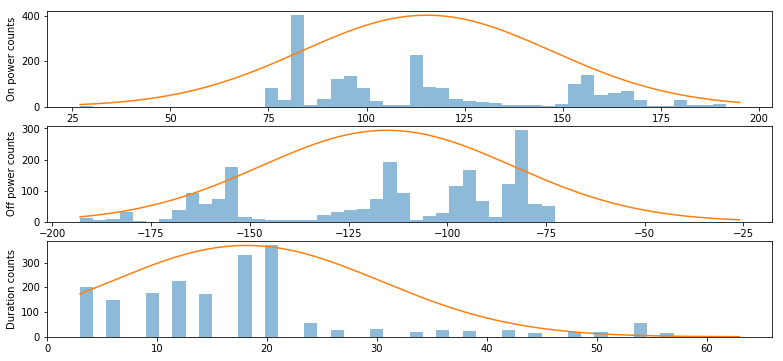

In [33]:
mle.train(metergroup)
mle.no_overfitting()
mle.featuresHist()

In [34]:
# Building to disaggregate: 
building = 1
mains = get_all_trainings(applianceName,test)

# File to store the disaggregation
filename= ('/Users/guptasoumya/Desktop/capstone_nilmtk/nilmtk/data/REDD/redd_mle_light1.h5')
output = HDFDataStore(filename, 'w')

Fetching  light  over data train data.
Building 1...
ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 2...
ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=5, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 4...
ElecMeter(instance=3, building=4, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 5...
ElecMeter(instance=4, building=5, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.
Building 6...
ElecMeter(instance=14, building=6, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
Fetched elec.


In [35]:
mle.disaggregate(mains, output)

Loading data for meter ElecMeterID(instance=14, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
60353 events found.
30602 onEvents found
11071 onEvents no paired.
1 chunks disaggregated


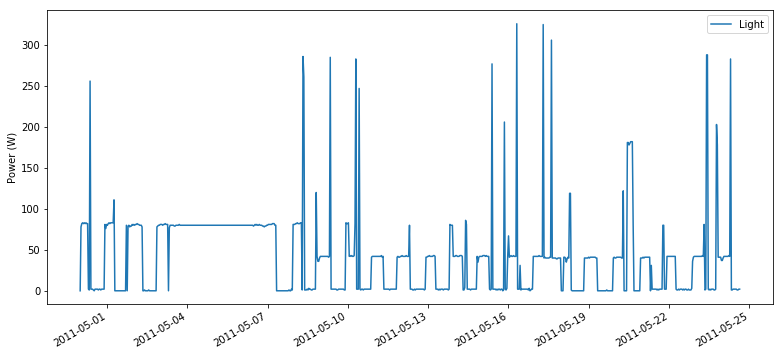

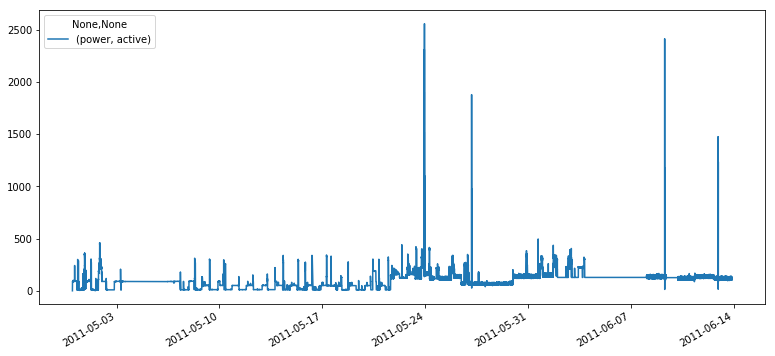

In [39]:
## Groundtruth
building1 = test.buildings[building].elec
building1[applianceName].plot()
pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]].plot()

In [37]:
test_output  = next(building1[applianceName].load())

predicted_output = pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]]

test_output = test_output.reset_index()
predicted_output = predicted_output.reset_index()

merge_output= test_output.merge(predicted_output, on= 'index',how='inner')

mae_light = mean_absolute_error(merge_output.iloc[:,1],merge_output.iloc[:,2])
mae_light

28.329752

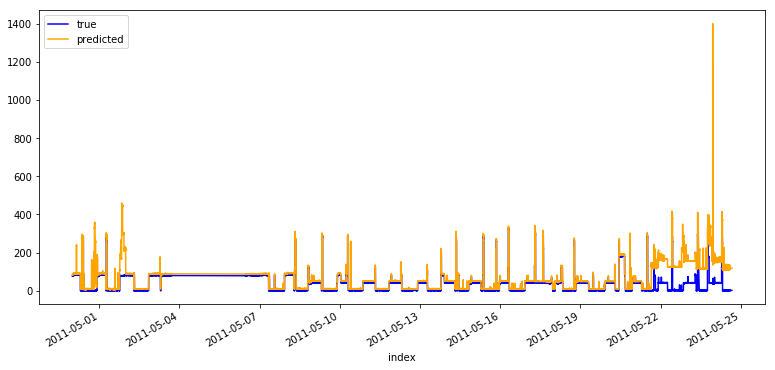

In [38]:
merge_output.set_index('index',inplace=True)
merge_output.iloc[:,0].plot(color='blue')
merge_output.iloc[:,1].plot(color='orange')
plt.legend(['true','predicted'])
plt.show()

## Microwave

In [40]:
applianceName = 'microwave'
metergroup = get_all_trainings(applianceName,train)

Fetching  microwave  over data train data.
Building 1...
ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
Fetched elec.
Building 2...
ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=16, building=3, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
Fetched elec.
Building 4...
Building 5...
ElecMeter(instance=3, building=5, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
Fetched elec.
Building 6...


In [41]:
mle = MLE()

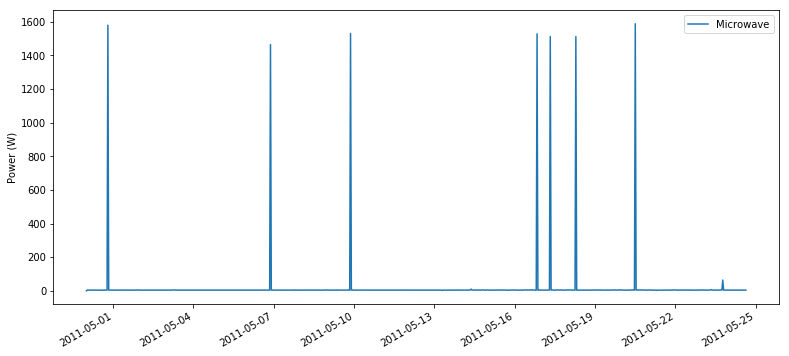

In [42]:
train.buildings[1].elec[applianceName].plot()

In [43]:

# setting parameters in the model: 
mle.update(appliance=applianceName, resistive=True, units=('power','active'), thDelta= 1000, thLikelihood= 1e-10, powerNoise= 5, powerPair= 1600, timeWindow= 10, sample_period= '3S', sampling_method='first')

# Settings the features parameters by guessing:  
mle.onpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.offpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.duration = {'name':'gmm', 'model': mixture.GMM(n_components=10)}

Updating model
{'appliance': 'microwave', 'resistive': True, 'units': ('power', 'active'), 'thDelta': 1000, 'thLikelihood': 1e-10, 'powerNoise': 5, 'powerPair': 1600, 'timeWindow': 10, 'sample_period': '3S', 'sampling_method': 'first'}


Training on chunk
Samples of onpower: 1306
Samples of offpower: 1306
Samples of duration: 1306
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 93
Samples of offpower: 93
Samples of duration: 93
Training onpower
Training offpower
Training duration
Training on chunk
Samples of onpower: 184
Samples of offpower: 184
Samples of duration: 184
Training onpower
Training offpower
Training duration
Training on chunk
            Is it thDelta too high?
Training onpower
Training offpower
Training duration
Training onpower
Training offpower
Training duration


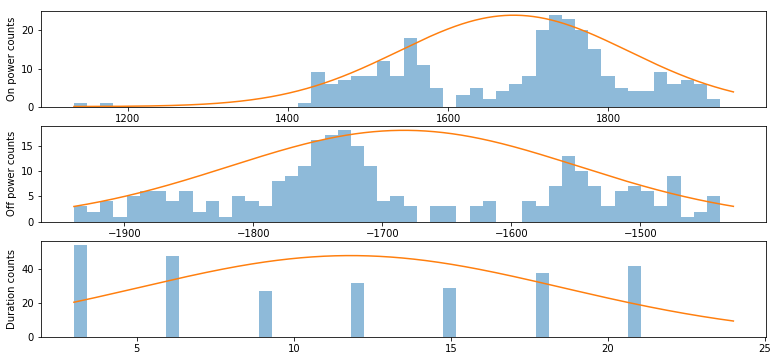

In [44]:
mle.train(metergroup)
mle.no_overfitting()
mle.featuresHist()

In [45]:
# Building to disaggregate: 
building = 1
mains = get_all_trainings(applianceName,test)

# File to store the disaggregation
filename= ('/Users/guptasoumya/Desktop/capstone_nilmtk/nilmtk/data/REDD/redd_mle_microwave1.h5')
output = HDFDataStore(filename, 'w')

Fetching  microwave  over data train data.
Building 1...
ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
Fetched elec.
Building 2...
ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=16, building=3, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
Fetched elec.
Building 4...
Building 5...
ElecMeter(instance=3, building=5, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
Fetched elec.
Building 6...


In [46]:
mle.disaggregate(mains, output)

Loading data for meter ElecMeterID(instance=3, building=5, dataset='REDD')      
Done loading data all meters for this chunk.
4791 events found.
2342 onEvents found
727 onEvents no paired.
1 chunks disaggregated


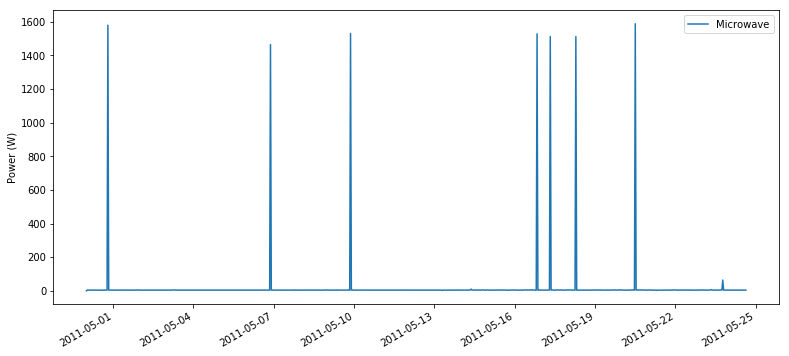

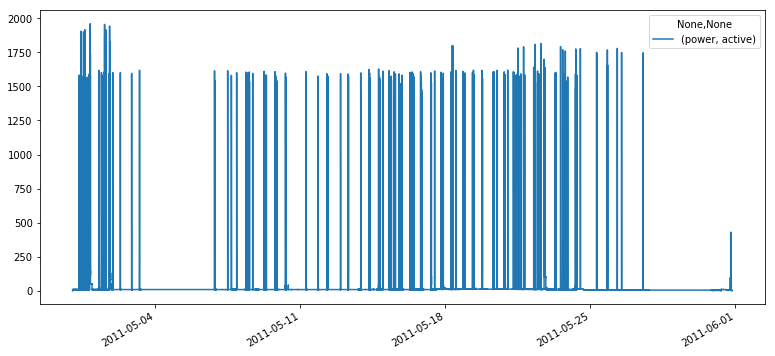

In [47]:
## Groundtruth
building1 = test.buildings[building].elec
building1[applianceName].plot()
pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]].plot()

In [48]:
test_output  = next(building1[applianceName].load())

predicted_output = pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]]

test_output = test_output.reset_index()
predicted_output = predicted_output.reset_index()

merge_output= test_output.merge(predicted_output, on= 'index',how='inner')

mle_microwave = mean_absolute_error(merge_output.iloc[:,1],merge_output.iloc[:,2])
mle_microwave

9.264734

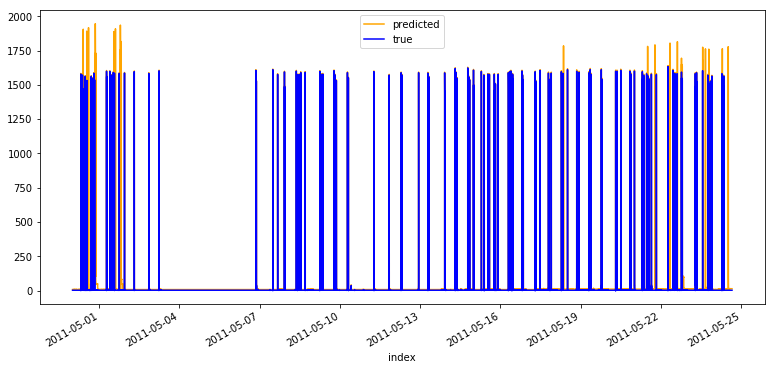

In [51]:
merge_output.set_index('index',inplace=True)
merge_output.iloc[:,1].plot(color='orange')
merge_output.iloc[:,0].plot(color='blue')
plt.legend(['predicted','true'])
plt.show()

## Washer dryer

In [69]:
train.buildings[1].elec['washer dryer'][10]

ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])

In [76]:
applianceName = 'washer dryer'
metergroup = get_all_trainings(applianceName,train)

Fetching  washer dryer  over data train data.
Building 1...
MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
)
Fetched elec.
Building 2...
ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Fetched elec.
Building 3...
MeterGroup(meters=
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
)
Fetched elec.
Building 4...
ElecMeter(instance=7, building=4, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Fetched elec.
Building 5...
MeterGroup(meters=
  ElecMeter(instance=8, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  El

In [72]:
mle = MLE()

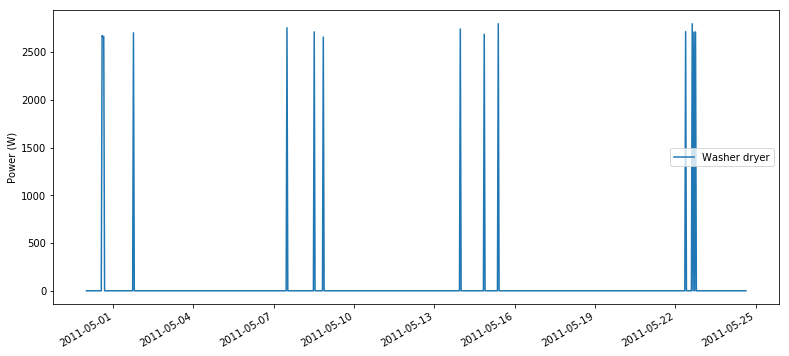

In [80]:
train.buildings[1].elec[applianceName][20].plot()

In [74]:

# setting parameters in the model: 
mle.update(appliance=applianceName, resistive=True, units=('power','active'), thDelta= 1000, thLikelihood= 1e-10, powerNoise= 5, powerPair= 3000, timeWindow= 10, sample_period= '3S', sampling_method='first')

# Settings the features parameters by guessing:  
mle.onpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.offpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.duration = {'name':'gmm', 'model': mixture.GMM(n_components=10)}

Updating model
{'appliance': 'washer dryer', 'resistive': True, 'units': ('power', 'active'), 'thDelta': 1000, 'thLikelihood': 1e-10, 'powerNoise': 5, 'powerPair': 3000, 'timeWindow': 10, 'sample_period': '3S', 'sampling_method': 'first'}


In [75]:
mle.train(metergroup)
mle.no_overfitting()
mle.featuresHist()

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
# Building to disaggregate: 
building = 1
mains = get_all_trainings(applianceName,test)

# File to store the disaggregation
filename= ('/Users/guptasoumya/Desktop/capstone_nilmtk/nilmtk/data/REDD/redd_mle_washerdryer1.h5')
output = HDFDataStore(filename, 'w')

In [ ]:
mle.disaggregate(mains, output)

In [ ]:
## Groundtruth
building1 = test.buildings[building].elec
building1[applianceName].plot()
pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]].plot()

In [ ]:
test_output  = next(building1[applianceName].load())

predicted_output = pd.HDFStore(filename)[pd.HDFStore(filename).keys()[0]]

test_output = test_output.reset_index()
predicted_output = predicted_output.reset_index()

merge_output= test_output.merge(predicted_output, on= 'index',how='inner')

mean_absolute_error(merge_output.iloc[:,1],merge_output.iloc[:,2])